Using device: cuda:0

1. Loading news data...

2. Loading behaviors data...

3. Creating news features...

4. Converting to tensor dictionary...


Epoch 1/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/157 [00:00<?, ?it/s]

Training complete!

1. Loading news data...

2. Loading behaviors data...

3. Creating news features...

4. Converting to tensor dictionary...


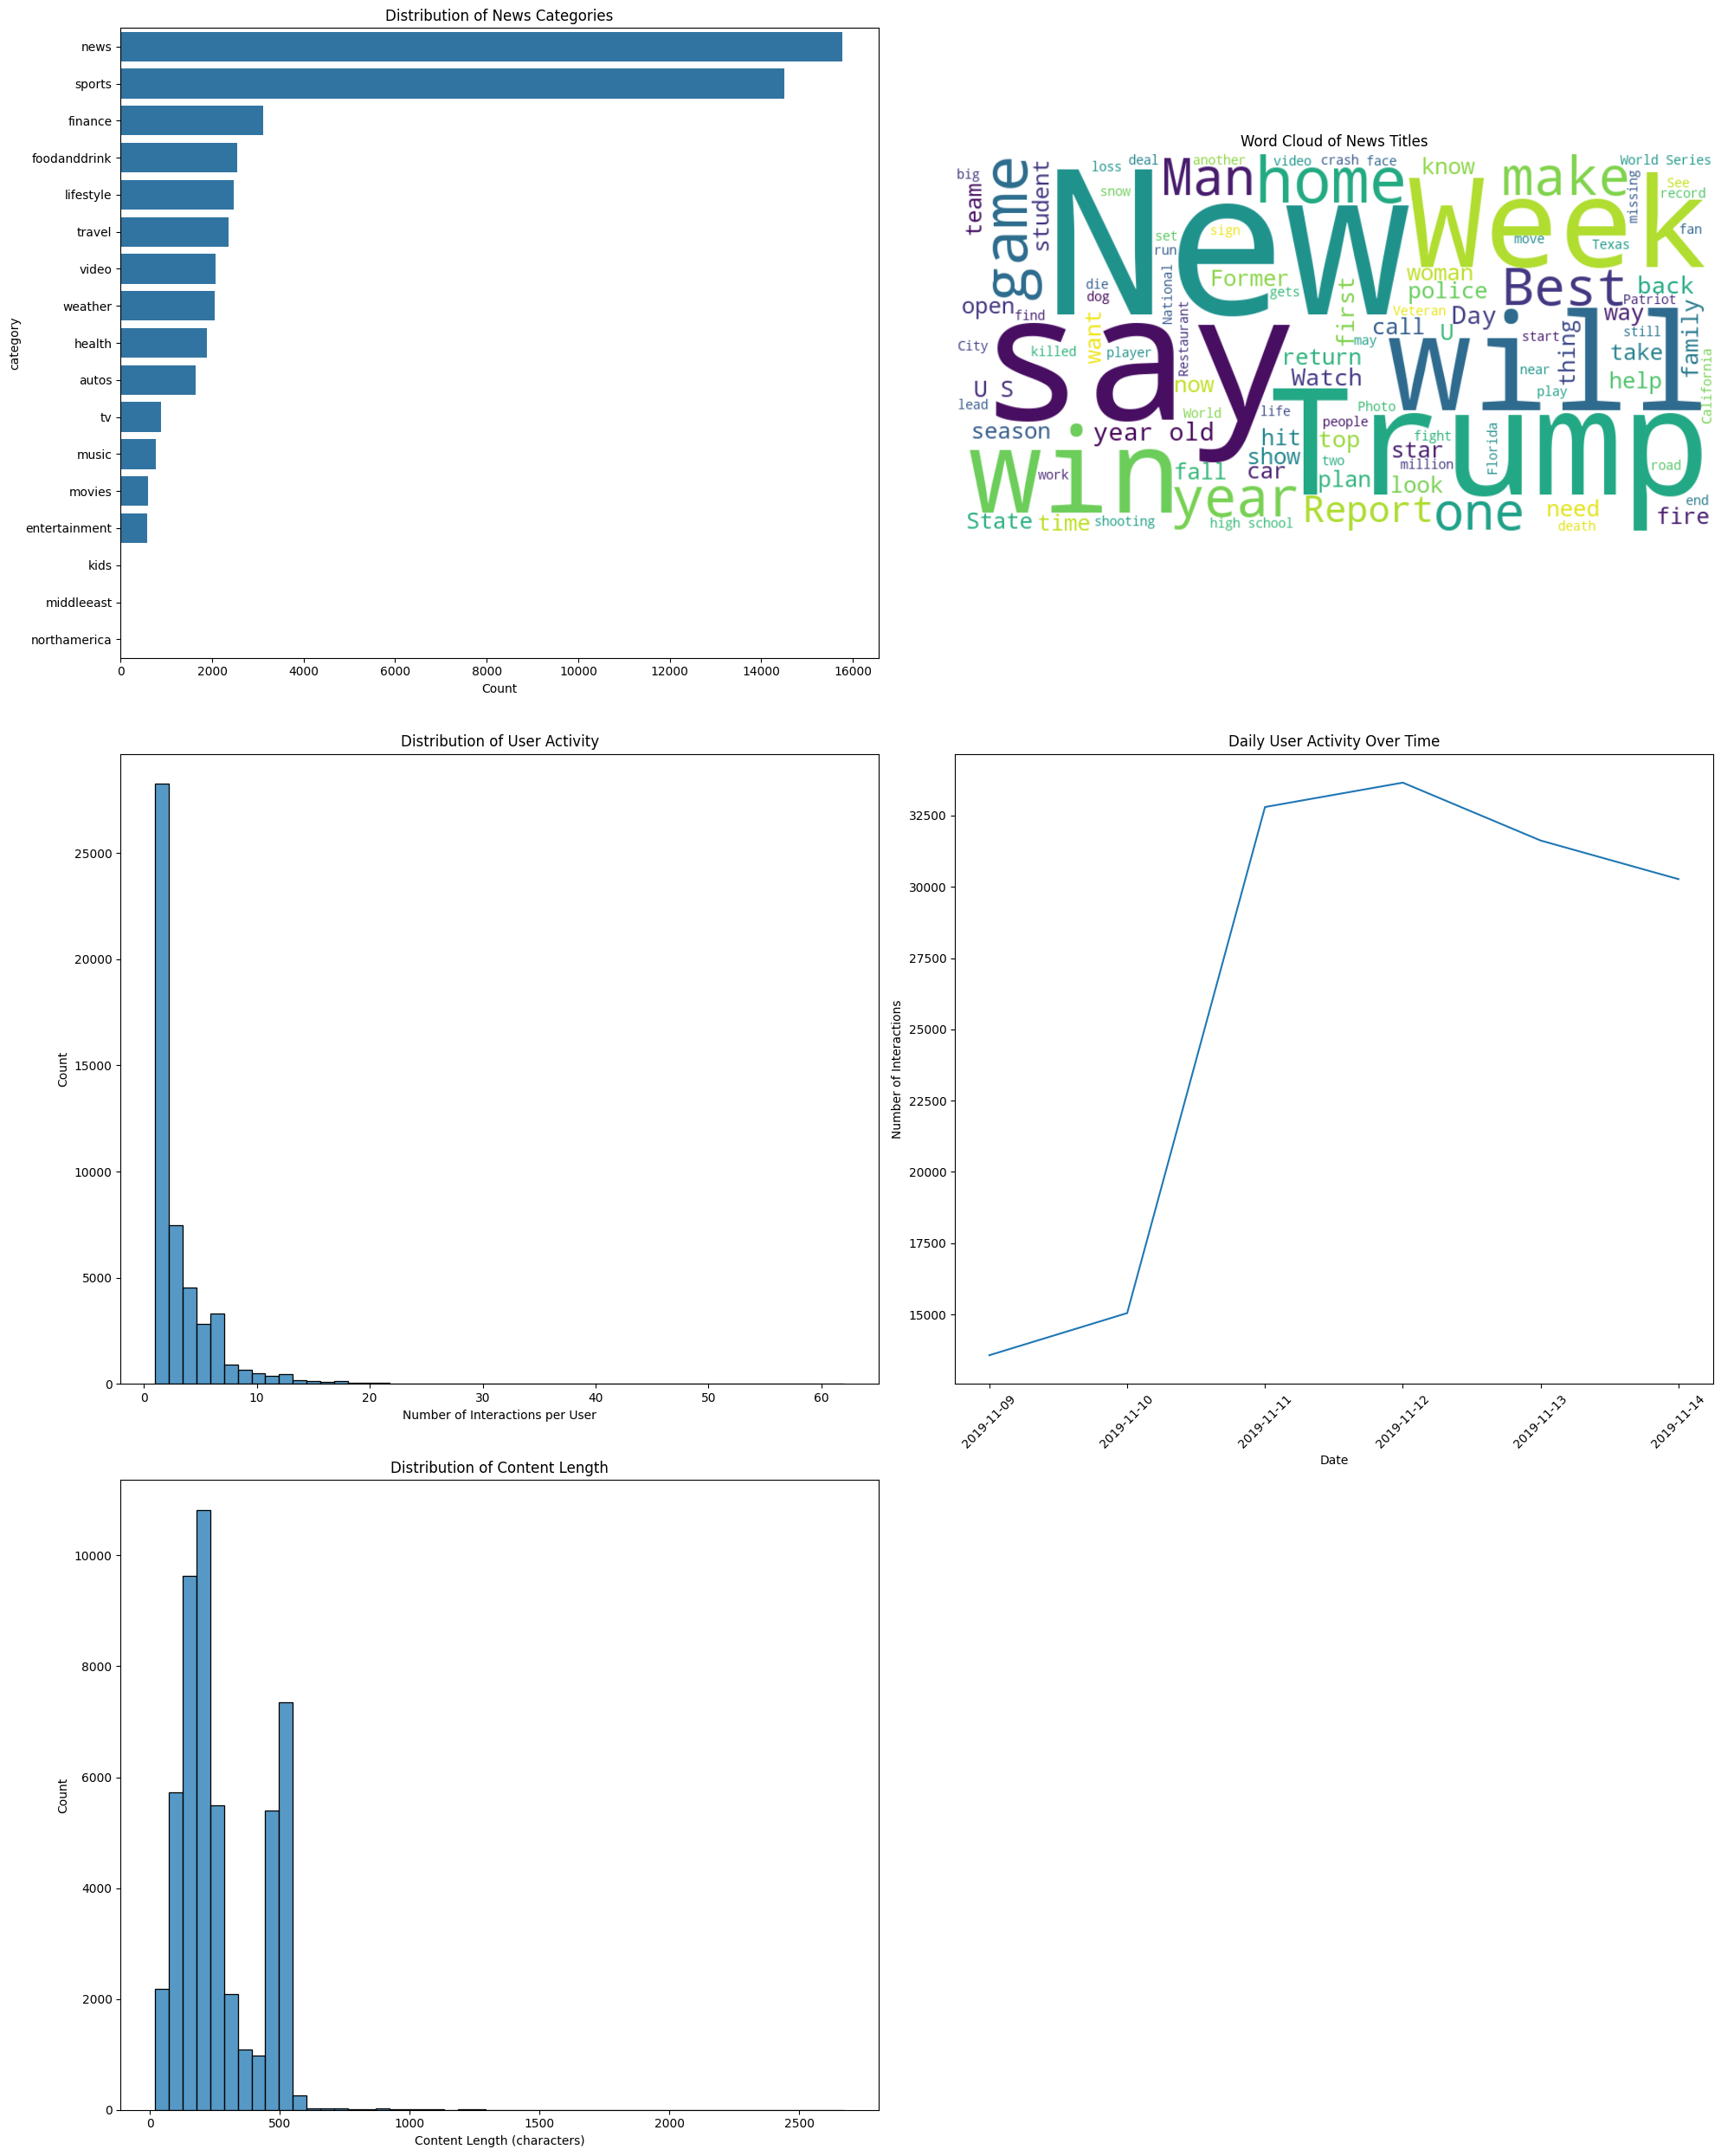

Error during visualization: float() argument must be a string or a real number, not 'dict'


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
BASE_PATH = r"C:\Users\nicla\DTU\CDTS"
NEWS_PATH = os.path.join(BASE_PATH, "news.tsv")
BEHAVIORS_PATH = os.path.join(BASE_PATH, "behaviors.tsv")

# Load
def load_news_data():
    news_df = pd.read_csv(NEWS_PATH, sep='\t', 
                         names=['news_id', 'category', 'subcategory', 'title', 
                               'abstract', 'url', 'title_entities', 'abstract_entities'])
    news_df['content'] = news_df['title'] + ' ' + news_df['abstract'].fillna('')
    return news_df

def load_behaviors_data():
    behaviors_df = pd.read_csv(BEHAVIORS_PATH, sep='\t',
                             names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
    return behaviors_df

def prepare_data():
    print("\n1. Loading news data...")
    news_df = load_news_data()
    
    print("\n2. Loading behaviors data...")
    behaviors_df = load_behaviors_data()
    
    print("\n3. Creating news features...")
    feature_extractor = TfidfVectorizer(max_features=1000)
    news_content = news_df['title'] + ' ' + news_df['abstract'].fillna('')
    news_features = feature_extractor.fit_transform(news_content)
    
    print("\n4. Converting to tensor dictionary...")
    news_features_dict = {}
    for i, news_id in enumerate(news_df['news_id']):
        news_features_dict[news_id] = torch.FloatTensor(news_features[i].toarray()).squeeze()
    
    return news_df, behaviors_df, news_features_dict

# Custom Dataset
class MINDDataset(Dataset):
    def __init__(self, user_history, news_features, negative_samples=4):
        self.user_history = user_history
        self.news_features = news_features
        self.negative_samples = negative_samples
        self.news_ids = list(news_features.keys())
        
    def __len__(self):
        return len(self.user_history)
    
    def __getitem__(self, idx):
        user_hist = self.user_history[idx]
        user_profile = torch.mean(torch.stack([self.news_features[h_id] 
                                             for h_id in user_hist if h_id in self.news_features]), dim=0)
        pos_news_id = np.random.choice(user_hist)
        pos_news_vector = self.news_features[pos_news_id]
        neg_samples = []
        while len(neg_samples) < self.negative_samples:
            neg_id = np.random.choice(self.news_ids)
            if neg_id not in user_hist:
                neg_samples.append(self.news_features[neg_id])
        neg_news_vectors = torch.stack(neg_samples)
        return user_profile, pos_news_vector, neg_news_vectors

class ContentRecommender(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.user_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.news_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
    
    def forward(self, user_profile, news_vector):
        user_emb = self.user_projection(user_profile)
        news_emb = self.news_projection(news_vector)
        return torch.sum(user_emb * news_emb, dim=-1)

def train_model(model, train_loader, optimizer, epochs=5):
    model.train()
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, (user_profiles, pos_news, neg_news) in enumerate(pbar):
            user_profiles = user_profiles.to(device)
            pos_news = pos_news.to(device)
            neg_news = neg_news.to(device)
            
            optimizer.zero_grad()
            pos_scores = model(user_profiles, pos_news)
            neg_scores = model(
                user_profiles.unsqueeze(1).repeat(1, neg_news.size(1), 1),
                neg_news
            )
            labels = torch.cat([
                torch.ones_like(pos_scores),
                torch.zeros_like(neg_scores.flatten())
            ]).to(device)
            scores = torch.cat([pos_scores, neg_scores.flatten()])
            loss = criterion(scores, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1
            pbar.set_postfix({'loss': f'{total_loss/batch_count:.4f}'})

def main():
    news_df, behaviors_df, news_features = prepare_data()
    
    user_histories = []
    for history in behaviors_df['history'].dropna():
        news_ids = history.split()
        if news_ids:
            user_histories.append(news_ids)
    
    dataset = MINDDataset(user_histories[:5000], news_features)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
    
    input_dim = next(iter(news_features.values())).shape[0]
    model = ContentRecommender(input_dim=input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    try:
        train_model(model, train_loader, optimizer, epochs=5)
        torch.save(model.state_dict(), 'content_recommender.pth')
        print("Training complete!")
    except Exception as e:
        print(f"Error during training: {str(e)}")
        raise e

def create_visualizations(news_df, behaviors_df, news_features):
    fig = plt.figure(figsize=(20, 25))
    
    try:
        plt.subplot(3, 2, 1)
        if 'category' in news_df.columns:
            category_counts = news_df['category'].value_counts()
            sns.barplot(x=category_counts.values, y=category_counts.index)
            plt.title('Distribution of News Categories')
            plt.xlabel('Count')
        
        plt.subplot(3, 2, 2)
        if 'title' in news_df.columns:
            text = ' '.join(news_df['title'].dropna())
            wordcloud = WordCloud(width=800, height=400, 
                                background_color='white',
                                max_words=100).generate(text)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('Word Cloud of News Titles')
        
        plt.subplot(3, 2, 3)
        user_activity = behaviors_df.groupby('user_id').size()
        sns.histplot(user_activity, bins=min(50, len(user_activity)//10))
        plt.title('Distribution of User Activity')
        plt.xlabel('Number of Interactions per User')
        plt.ylabel('Count')
        
        plt.subplot(3, 2, 4)
        behaviors_df['time'] = pd.to_datetime(behaviors_df['time'])
        daily_activity = behaviors_df.groupby(behaviors_df['time'].dt.date).size()
        plt.plot(daily_activity.index, daily_activity.values)
        plt.title('Daily User Activity Over Time')
        plt.xlabel('Date')
        plt.ylabel('Number of Interactions')
        plt.xticks(rotation=45)
        
        plt.subplot(3, 2, 5)
        if 'content' in news_df.columns:
            news_df['content_length'] = news_df['content'].str.len()
            sns.histplot(data=news_df, x='content_length', bins=min(50, len(news_df)//10))
            plt.title('Distribution of Content Length')
            plt.xlabel('Content Length (characters)')
            plt.ylabel('Count')

        plt.tight_layout()
        plt.show()
        
        # PCA visualization
        news_features_array = news_features.toarray() if hasattr(news_features, 'toarray') else news_features
        pca = PCA(n_components=2)
        news_pca = pca.fit_transform(news_features_array)
        
        sample_size = min(1000, len(news_pca))
        sample_indices = np.random.choice(len(news_pca), sample_size, replace=False)
        
        fig = px.scatter(
            x=news_pca[sample_indices, 0],
            y=news_pca[sample_indices, 1],
            color=news_df['category'].iloc[sample_indices] if 'category' in news_df.columns else None,
            title='PCA Visualization of News Embeddings',
            labels={'color': 'Category'}
        )
        fig.show()

        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        print(f"Total number of news articles: {len(news_df)}")
        print(f"Total number of users: {behaviors_df['user_id'].nunique()}")
        if 'content_length' in news_df.columns:
            print(f"Average content length: {news_df['content_length'].mean():.2f} characters")
    except Exception as e:
        print(f"Error during visualization: {str(e)}")

# main
main()
create_visualizations(*prepare_data())
